- To get data, you need to download the data from the following link: https://www.kaggle.com/datasets/hsallrounder/plantvillage

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2 as cv
import keras
import os
import sys
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
CROP_LIST = ['Apple', 'Cherry', 'Corn', 'Grape', 'Peach', 'Pepper', 'Strawberry']
SELECTED_CROP = 'Cherry'

In [3]:
# load data

def load_image(image_id:str):
    image_id = image_id.split('.')[0] if image_id.endswith('.jpg') else image_id.split('.')[0] if image_id.endswith('.JPG') else image_id
    file_path = image_id + ".jpg"
    image = cv.imread(file_path)
    return cv.cvtColor(image, cv.COLOR_BGR2RGB)

def load_data(crop_name) -> dict:
    # load data
    data_dir = '../data/PlantVillage'
    os.chdir(data_dir)
    dir_list = [x for x in os.listdir() if x.startswith(crop_name)]
    dir_list.sort()
    data = dict()
    for dir_name in dir_list:
        os.chdir(dir_name)
        image_list = [load_image(x) for x in os.listdir() if x.lower().endswith('.jpg')]
        print(dir_name, len(image_list))
        data[dir_name] = image_list
        os.chdir('..')
    os.chdir('../../main')
    return data

In [4]:
#plot image
def plot_image(image):
    plt.imshow(image)
    plt.axis('off')
    plt.show()

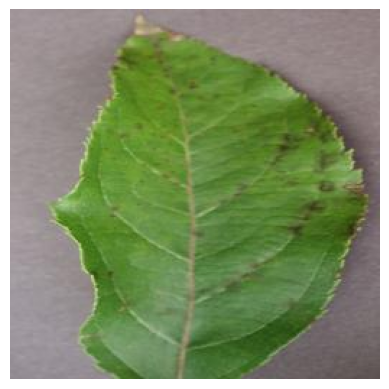

In [5]:
# TEST CODE
test_jpg = load_image('../data/PlantVillage/Apple___Apple_scab/image (1)')
plot_image(test_jpg)

In [6]:
# load all data
data = load_data(SELECTED_CROP)
NUM_CLASSES = len(data.keys())
print(f"Number of classes: {len(data.keys())}, Number of images: {sum([len(x) for x in data.values()])}")

Cherry___Powdery_mildew 1052
Cherry___healthy 854
Number of classes: 2, Number of images: 1906


In [7]:
# normalize data
def normalize_data(data: dict) -> dict:
    return {k: [x/255.0 for x in v] for k, v in data.items()}

In [8]:
nor_data = normalize_data(data)
print(f"Number of classes: {len(nor_data.keys())}, Number of images: {sum([len(x) for x in nor_data.values()])}")

Number of classes: 2, Number of images: 1906


In [9]:
df = pd.DataFrame({'image': [x for x in nor_data.values() for x in x], 'label': [x for x in nor_data.keys() for _ in range(len(nor_data[x]))]})
df.head()

,image,label
0,"[[[0.6313725490196078, 0.615686274509804, 0.60...",Cherry___Powdery_mildew
1,"[[[0.6196078431372549, 0.5725490196078431, 0.5...",Cherry___Powdery_mildew
2,"[[[0.37254901960784315, 0.32941176470588235, 0...",Cherry___Powdery_mildew
3,"[[[0.4, 0.35294117647058826, 0.360784313725490...",Cherry___Powdery_mildew
4,"[[[0.49019607843137253, 0.4470588235294118, 0....",Cherry___Powdery_mildew


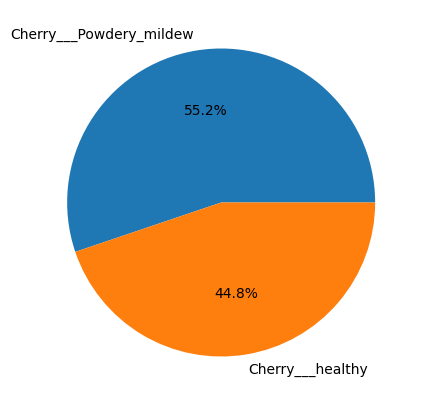

In [10]:
# plot pie chart of data(labels)
def plot_pie_chart(data: dict):
    plt.figure(figsize=(5, 5))
    plt.pie([len(x) for x in data.values()], labels=[x for x in data.keys()], autopct='%1.1f%%')
    plt.show()

plot_pie_chart(nor_data)

In [11]:
# label encoding
le = LabelEncoder()
le.fit(df['label'])
df['label'] = le.transform(df['label'])
print(le.classes_)

['Cherry___Powdery_mildew' 'Cherry___healthy']


In [12]:
# turn data into numpy array and split into train and test
def split_data(data: dict, test_size: float=0.2) -> tuple:
    X = np.array([x for x in data['image']])
    y = np.array([x for x in data['label']])
    return train_test_split(X, y, test_size=test_size, random_state=42)

X_train, X_test, y_train, y_test = split_data(df)

In [13]:
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (1524, 256, 256, 3), y_train shape: (1524,)
X_test shape: (382, 256, 256, 3), y_test shape: (382,)


In [14]:
# create model
model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 128)     

In [15]:
# train model

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10


38/48 [======================>.......] - ETA: 5s - loss: 1.0305 - accuracy: 0.6497